In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from pathlib import Path
from xml.dom.minidom import parse
from shutil import copyfile
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hard-hat-detection/annotations/hard_hat_workers1531.xml
/kaggle/input/hard-hat-detection/annotations/hard_hat_workers4092.xml
/kaggle/input/hard-hat-detection/annotations/hard_hat_workers2006.xml
/kaggle/input/hard-hat-detection/annotations/hard_hat_workers3414.xml
/kaggle/input/hard-hat-detection/annotations/hard_hat_workers4190.xml
/kaggle/input/hard-hat-detection/annotations/hard_hat_workers324.xml
/kaggle/input/hard-hat-detection/annotations/hard_hat_workers4181.xml
/kaggle/input/hard-hat-detection/annotations/hard_hat_workers3912.xml
/kaggle/input/hard-hat-detection/annotations/hard_hat_workers3704.xml
/kaggle/input/hard-hat-detection/annotations/hard_hat_workers4740.xml
/kaggle/input/hard-hat-detection/annotations/hard_hat_workers714.xml
/kaggle/input/hard-hat-detection/annotations/hard_hat_workers486.xml
/kaggle/input/hard-hat-detection/annotations/hard_hat_workers1331.xml
/kaggle/input/hard-hat-detection/annotations/hard_hat_workers3623.xml
/kaggle/input/hard-hat-

In [2]:
!pip install ultralytics supervision pandas pycocotools scikit-learn plotly wandb -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.9 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
!mkdir -p Dataset/labels
!mkdir -p Dataset/images

In [4]:
classes = ['helmet','head','person']


In [5]:
def convert_annot(size , box):
    x1 = int(box[0])
    y1 = int(box[1])
    x2 = int(box[2])
    y2 = int(box[3])

    dw = np.float32(1. / int(size[0]))
    dh = np.float32(1. / int(size[1]))

    w = x2 - x1
    h = y2 - y1
    x = x1 + (w / 2)
    y = y1 + (h / 2)

    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return [x, y, w, h]

In [6]:
def save_txt_file(img_jpg_file_name, size, img_box):
    save_file_name = '/kaggle/working/Dataset/labels/' +  img_jpg_file_name + '.txt'
    
    #file_path = open(save_file_name, "a+")
    with open(save_file_name ,'a+') as file_path:
        for box in img_box:

            cls_num = classes.index(box[0])

            new_box = convert_annot(size, box[1:])

            file_path.write(f"{cls_num} {new_box[0]} {new_box[1]} {new_box[2]} {new_box[3]}\n")

        file_path.flush()
        file_path.close()

In [7]:
def get_xml_data(file_path, img_xml_file):
    img_path = file_path + '/' + img_xml_file + '.xml'
    #print(img_path)

    dom = parse(img_path)
    root = dom.documentElement
    img_name = root.getElementsByTagName("filename")[0].childNodes[0].data
    img_size = root.getElementsByTagName("size")[0]
    objects = root.getElementsByTagName("object")
    img_w = img_size.getElementsByTagName("width")[0].childNodes[0].data
    img_h = img_size.getElementsByTagName("height")[0].childNodes[0].data
    img_c = img_size.getElementsByTagName("depth")[0].childNodes[0].data
   
    img_box = []
    for box in objects:
        cls_name = box.getElementsByTagName("name")[0].childNodes[0].data
        x1 = int(box.getElementsByTagName("xmin")[0].childNodes[0].data)
        y1 = int(box.getElementsByTagName("ymin")[0].childNodes[0].data)
        x2 = int(box.getElementsByTagName("xmax")[0].childNodes[0].data)
        y2 = int(box.getElementsByTagName("ymax")[0].childNodes[0].data)
        
        img_jpg_file_name = img_xml_file + '.jpg'
        img_box.append([cls_name, x1, y1, x2, y2])
  

    # test_dataset_box_feature(img_jpg_file_name, img_box)
    save_txt_file(img_xml_file, [img_w, img_h], img_box)

In [8]:
!ls /kaggle/working/Dataset/labels


In [9]:
files = os.listdir('/kaggle/input/hard-hat-detection/annotations')
for file in files:
    file_xml = file.split(".")
    get_xml_data('/kaggle/input/hard-hat-detection/annotations', file_xml[0])

In [10]:
from sklearn.model_selection import train_test_split
image_list = os.listdir('/kaggle/input/hard-hat-detection/images')
train_list, test_list = train_test_split(image_list, test_size=0.2, random_state=42)
val_list, test_list = train_test_split(test_list, test_size=0.5, random_state=42)
print('total =',len(image_list))
print('train :',len(train_list))
print('val   :',len(val_list))
print('test  :',len(test_list))

total = 5000
train : 4000
val   : 500
test  : 500


In [11]:
def copy_data(file_list, img_labels_root, imgs_source, mode):

    root_file = Path( '/kaggle/working/Dataset/images/'+  mode)
    if not root_file.exists():
        print(f"Path {root_file} does not exit")
        os.makedirs(root_file)

    root_file = Path('/kaggle/working/Dataset/labels/' + mode)
    if not root_file.exists():
        print(f"Path {root_file} does not exit")
        os.makedirs(root_file)

    for file in file_list:               
        img_name = file.replace('.png', '')        
        img_src_file = imgs_source + '/' + img_name + '.png'        
        label_src_file = img_labels_root + '/' + img_name + '.txt'

        #print(img_sor_file)
        #print(label_sor_file)
        # im = Image.open(rf"{img_sor_file}")
        # im.show()

        # Copy image
        DICT_DIR = '/kaggle/working/Dataset/images/'  + mode
        img_dict_file = DICT_DIR + '/' + img_name + '.png'

        copyfile(img_src_file, img_dict_file)

        # Copy label
        DICT_DIR = '/kaggle/working/Dataset/labels/' + mode
        img_dict_file = DICT_DIR + '/' + img_name + '.txt'
        copyfile(label_src_file, img_dict_file)

In [12]:
copy_data(train_list, '/kaggle/working/Dataset/labels', '/kaggle/input/hard-hat-detection/images', "train")
copy_data(val_list,   '/kaggle/working/Dataset/labels', '/kaggle/input/hard-hat-detection/images', "val")
copy_data(test_list,  '/kaggle/working/Dataset/labels', '/kaggle/input/hard-hat-detection/images', "test")

Path /kaggle/working/Dataset/images/train does not exit
Path /kaggle/working/Dataset/labels/train does not exit
Path /kaggle/working/Dataset/images/val does not exit
Path /kaggle/working/Dataset/labels/val does not exit
Path /kaggle/working/Dataset/images/test does not exit
Path /kaggle/working/Dataset/labels/test does not exit


In [13]:
!ls /kaggle/working/Dataset/images


test  train  val


In [14]:
!git clone https://github.com/ultralytics/ultralytics
!pip install ultralytics

Cloning into 'ultralytics'...
remote: Enumerating objects: 62488, done.
remote: Counting objects: 100% (516/516), done.
remote: Compressing objects: 100% (299/299), done.
remote: Total 62488 (delta 421), reused 217 (delta 217), pack-reused 61972 (from 3)
Receiving objects: 100% (62488/62488), 34.07 MiB | 29.77 MiB/s, done.
Resolving deltas: 100% (46454/46454), done.


In [15]:
import yaml

# Create configuration
config = {
   "path": "/kaggle/working/Dataset/images",
   "train": "train",
   "val": "val",
   "test": "test",
   "nc": 3,
   "names": ['helmet','head','person']
}
with open("data.yaml", "w") as file:
   yaml.dump(config, file, default_flow_style=False)

In [16]:
!cat data.yaml


names:
- helmet
- head
- person
nc: 3
path: /kaggle/working/Dataset/images
test: test
train: train
val: val


In [17]:
!wandb disabled


W&B disabled.


In [18]:
!yolo task=detect mode=train data=data.yaml model=yolov8s.pt epochs=20 lr0=0.01


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
100%|███████████████████████████████████████| 21.5M/21.5M [00:00<00:00, 170MB/s]
Ultralytics 8.3.166 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv

In [19]:
!ls /kaggle/working/runs/detect/train


args.yaml			 labels.jpg	      train_batch2.jpg
BoxF1_curve.png			 results.csv	      val_batch0_labels.jpg
BoxP_curve.png			 results.png	      val_batch0_pred.jpg
BoxPR_curve.png			 train_batch0.jpg     val_batch1_labels.jpg
BoxR_curve.png			 train_batch1.jpg     val_batch1_pred.jpg
confusion_matrix_normalized.png  train_batch2500.jpg  val_batch2_labels.jpg
confusion_matrix.png		 train_batch2501.jpg  val_batch2_pred.jpg
labels_correlogram.jpg		 train_batch2502.jpg  weights


In [20]:
from IPython.display import Image, clear_output
import matplotlib.pyplot as plt
%matplotlib inline

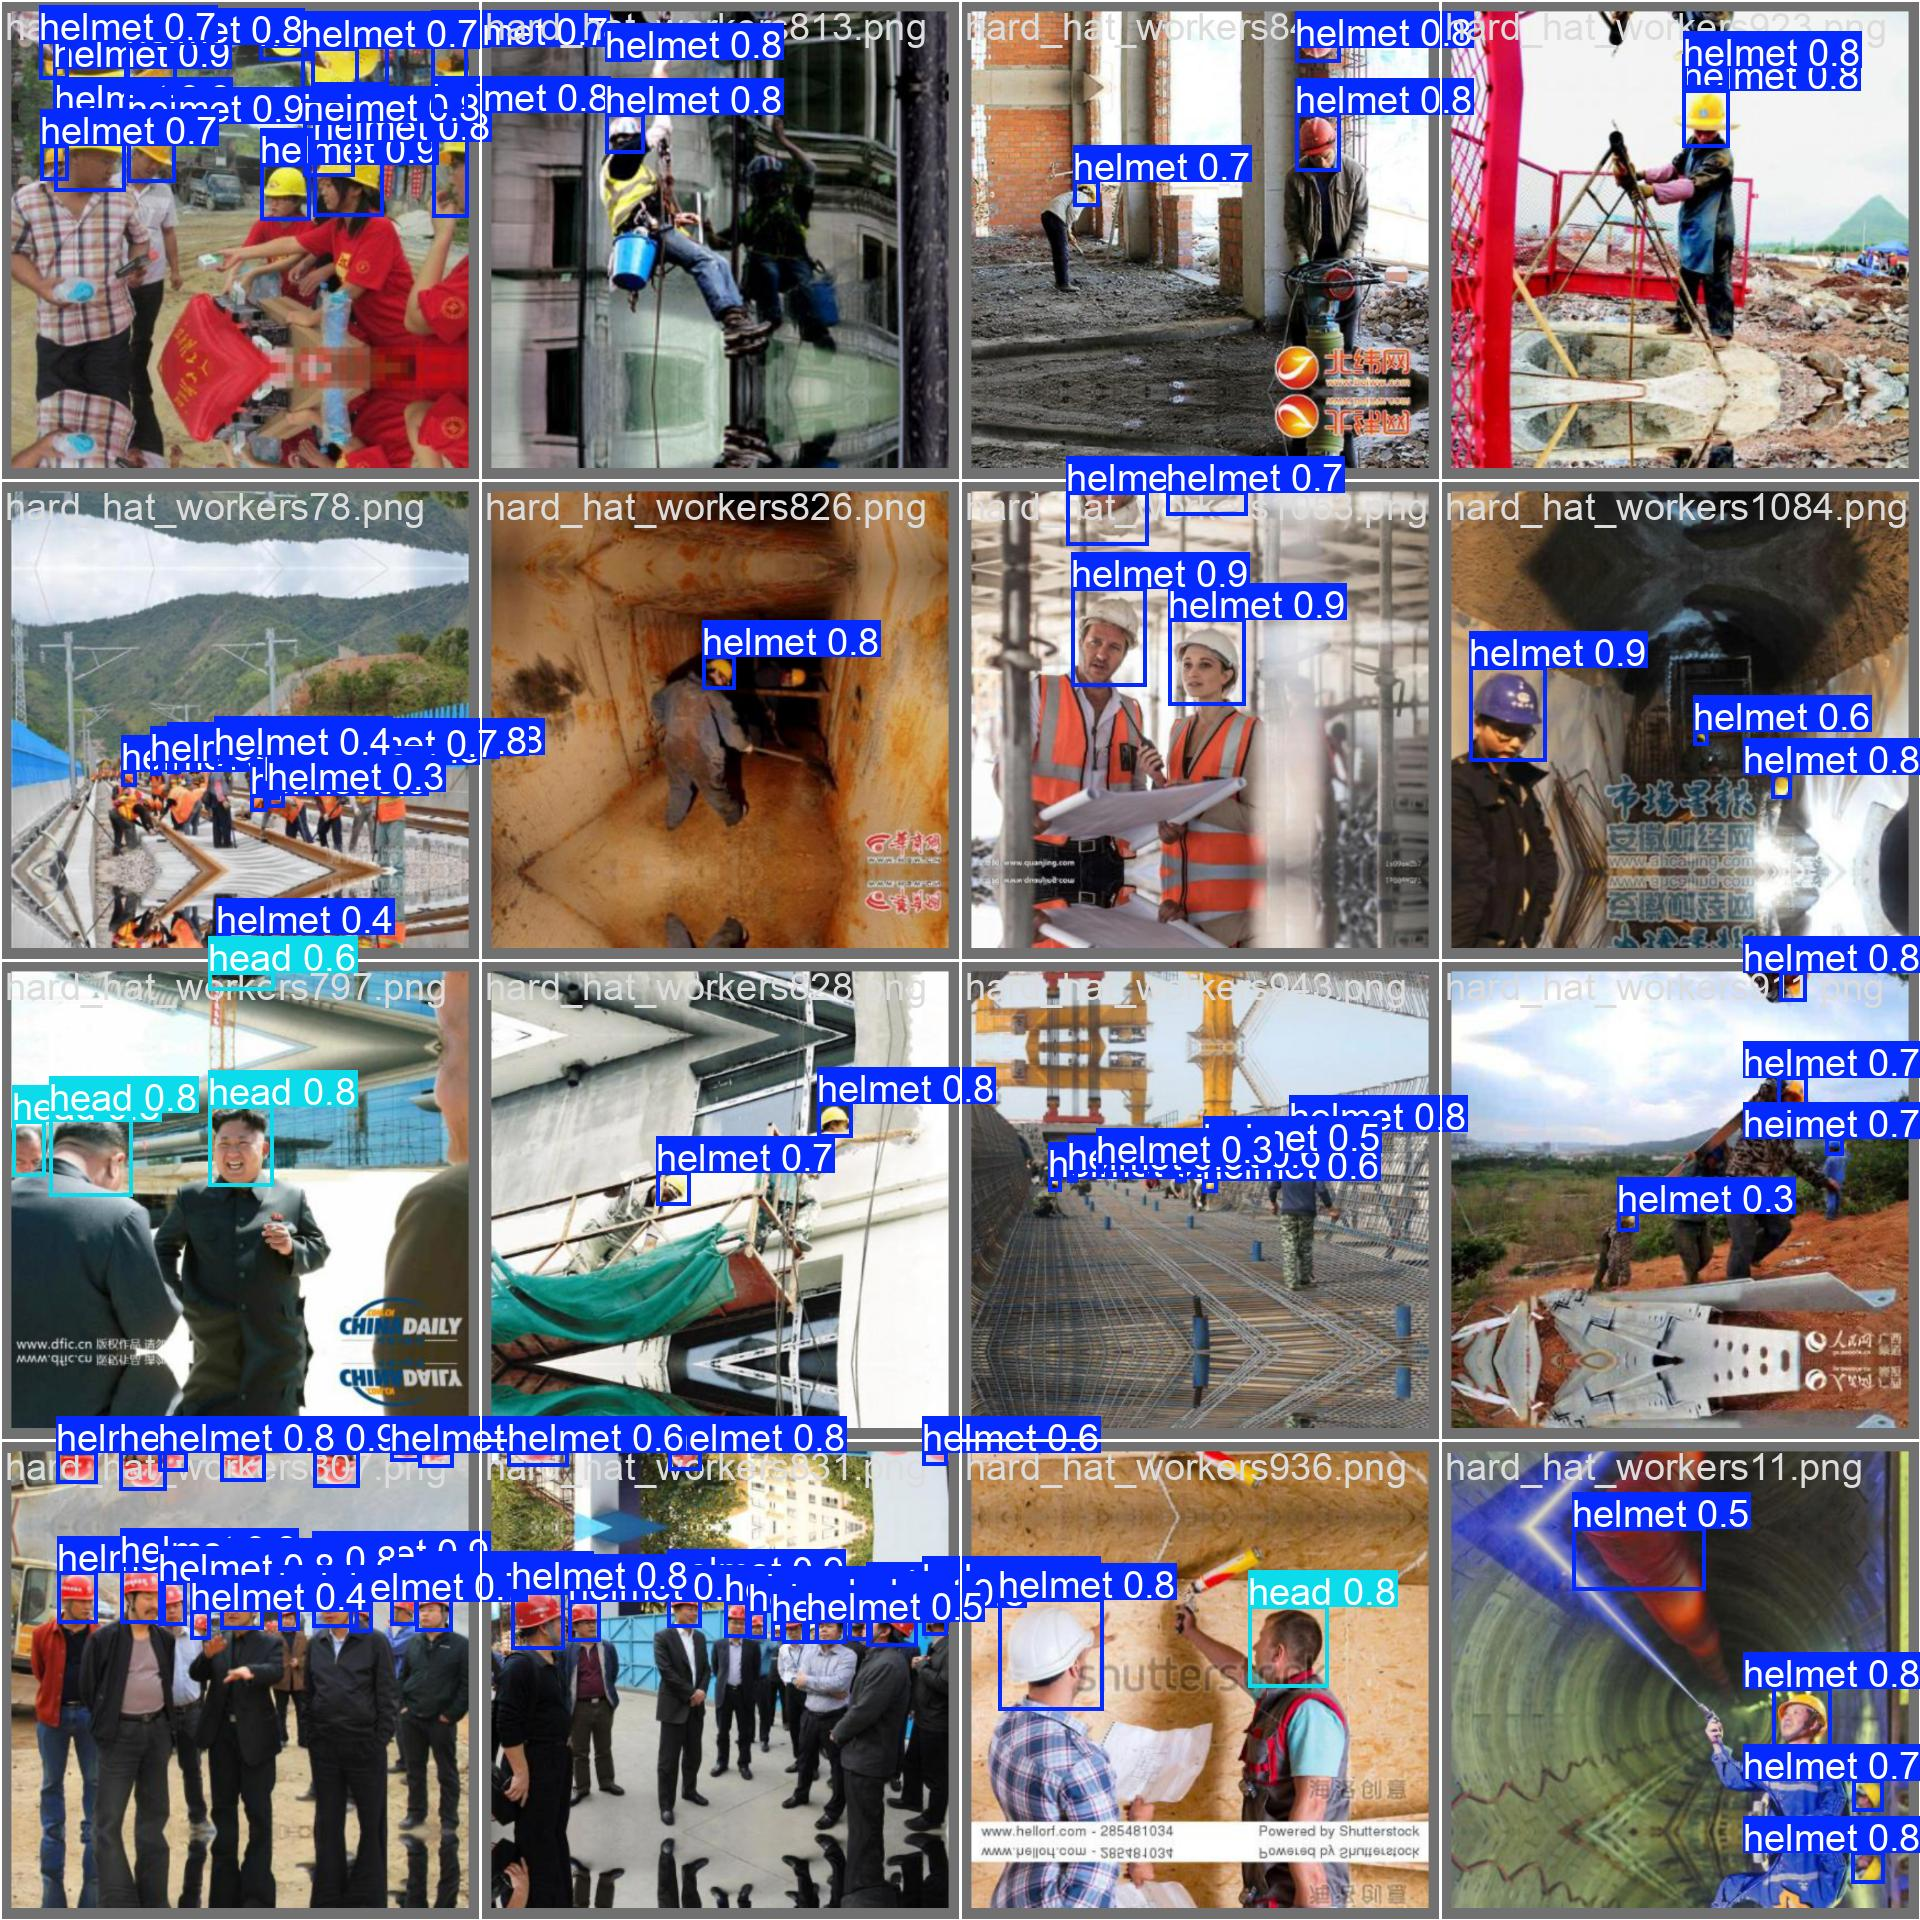

In [23]:
Image(filename='/kaggle/working/runs/detect/train/val_batch0_pred.jpg', width=1000)


In [24]:
!yolo task=detect mode=val model=/kaggle/working/runs/detect/train/weights/best.pt data=data.yaml


Ultralytics 8.3.166 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2805.6±1981.0 MB/s, size: 227.8 KB)
val: Scanning /kaggle/working/Dataset/labels/val.cache... 500 images, 0 backgrou
                 Class     Images  Instances      Box(P          R      mAP50  m
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
                   all        500       2422      0.953      0.579      0.636      0.422
                helmet        472       1922      0.949      0.901      0.958      0.634
                  head         80        396      0.909      0.835      0.908      0.609
                person         24        104        

Displaying a sample prediction image from the validation set:


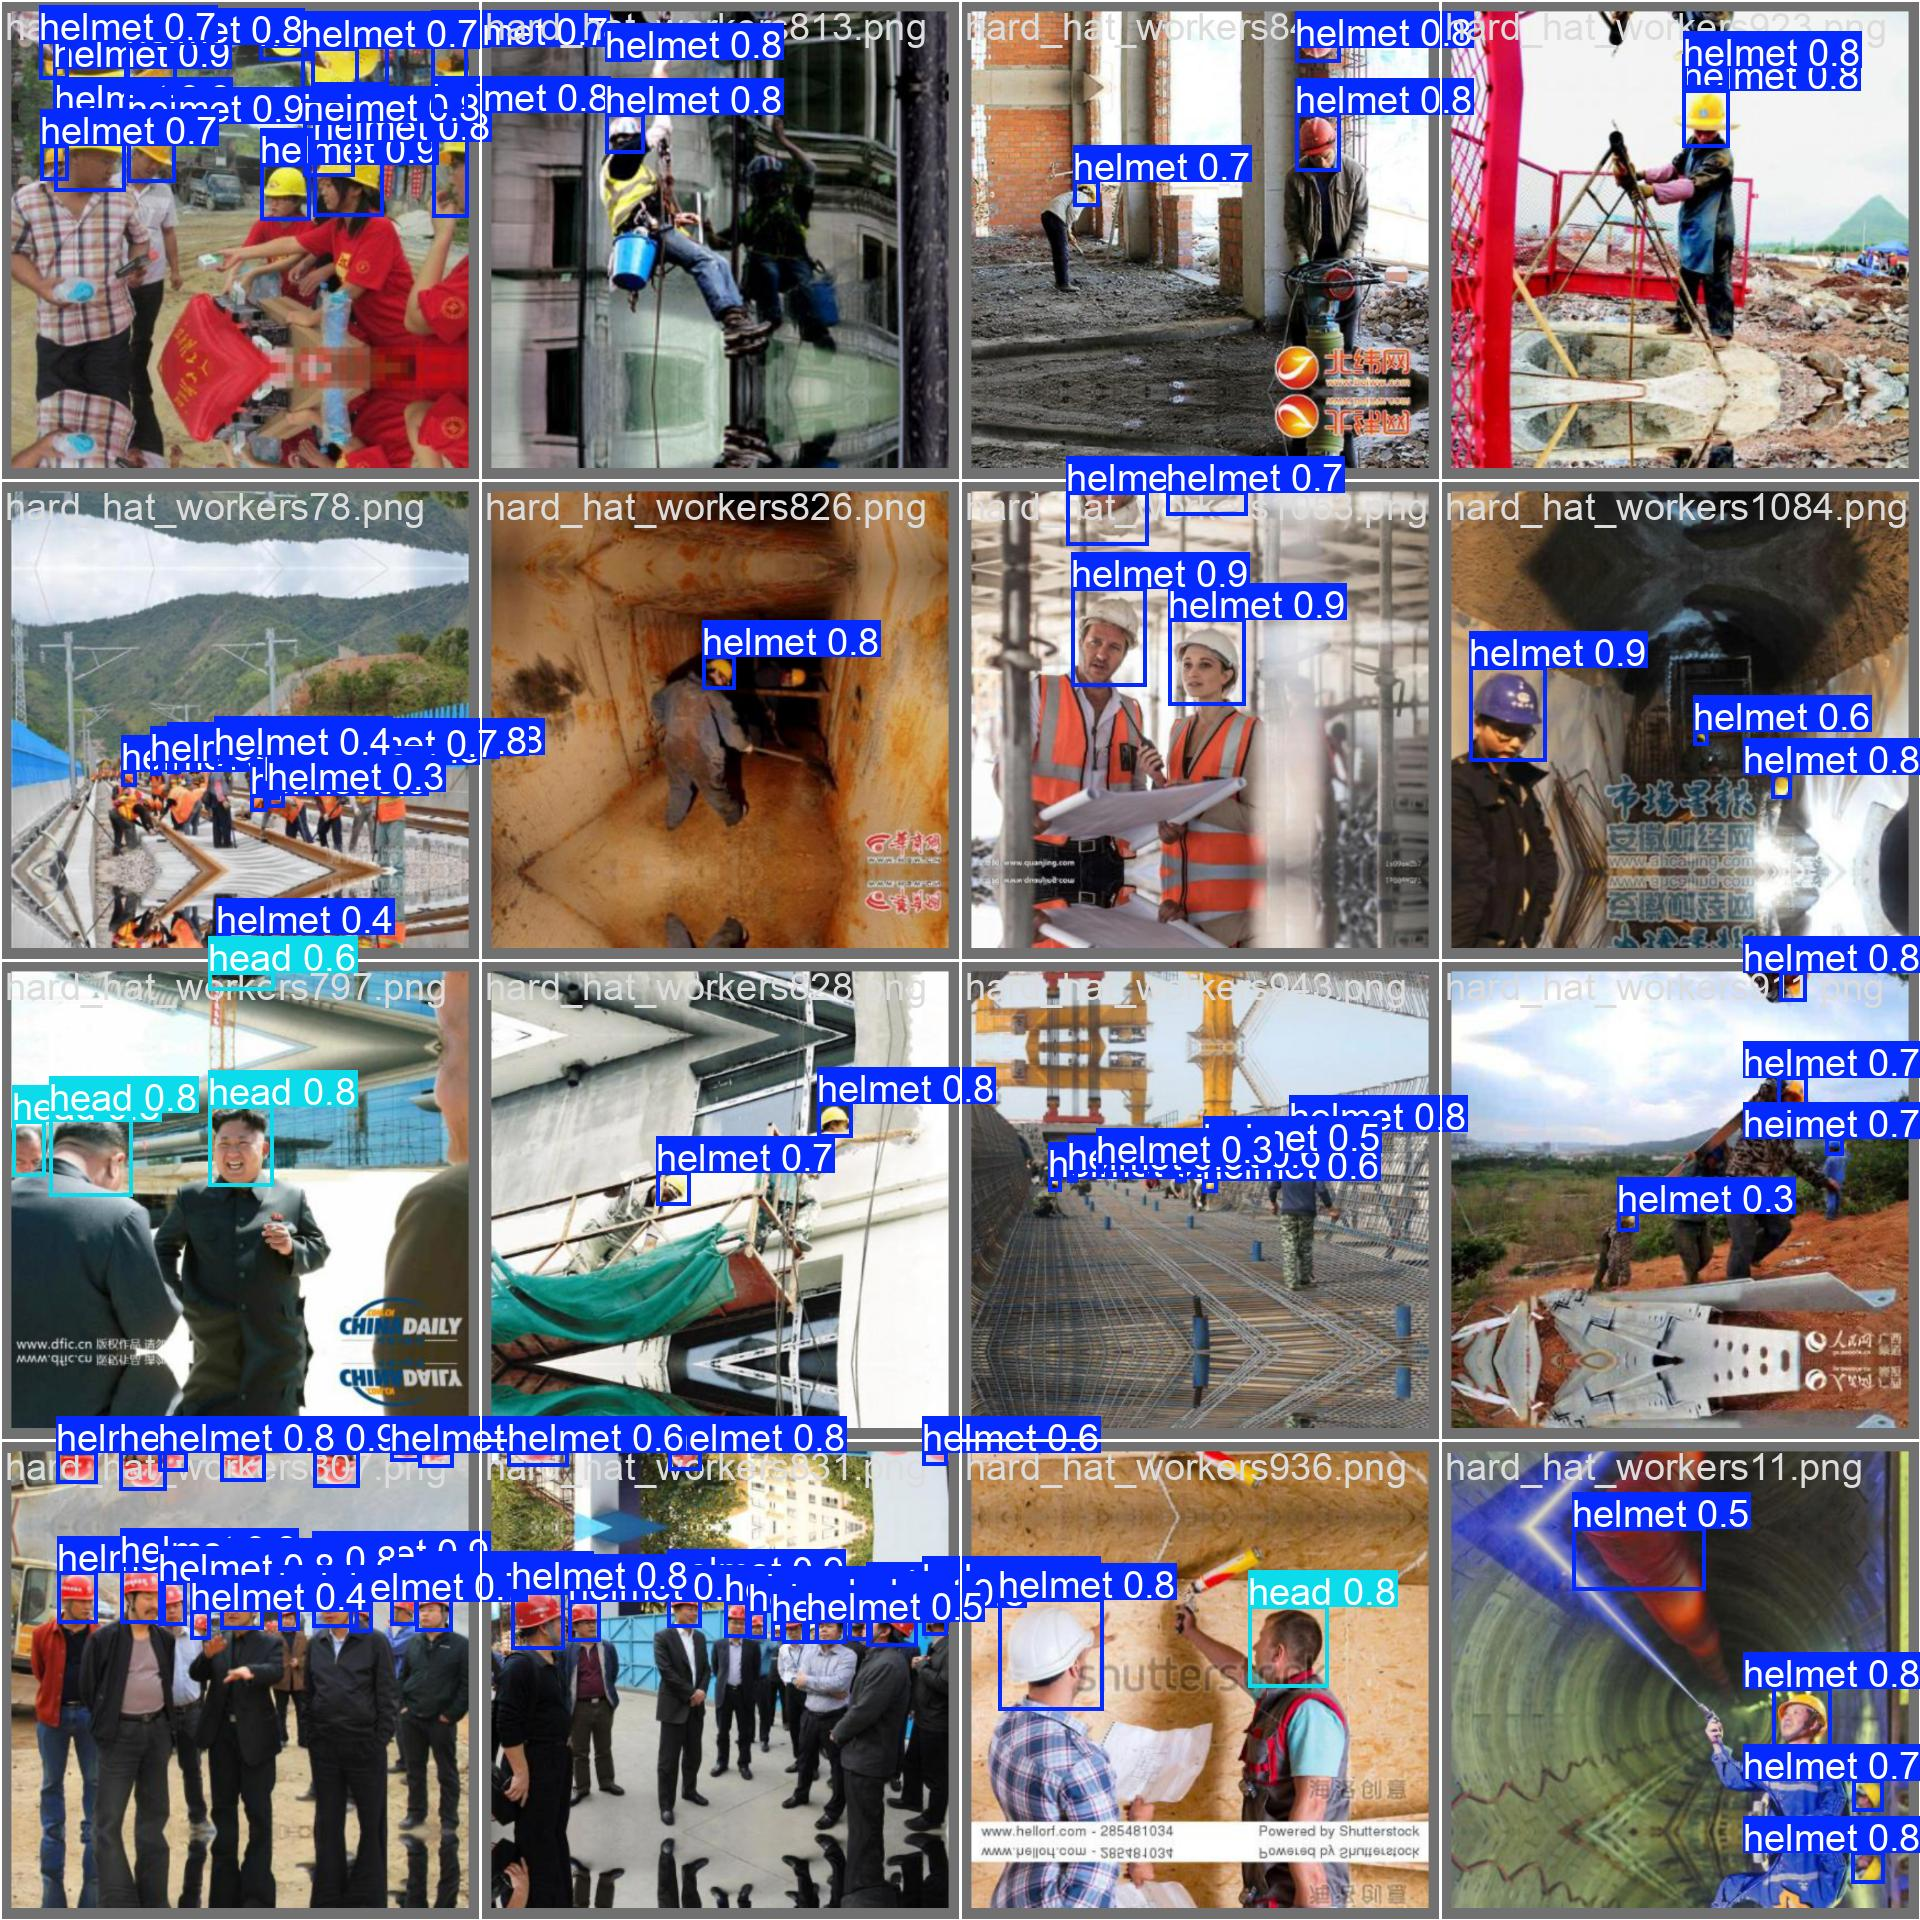

✅ Sample prediction image displayed from: /kaggle/working/runs/detect/train/val_batch0_pred.jpg

Listing important plot files generated by YOLOv8 training:
❌ Plot NOT found: F1_curve.png
✅ Found plot: confusion_matrix.png
✅ Found plot: results.png
✅ Found plot: val_batch0_labels.jpg
✅ Found plot: val_batch0_pred.jpg

Some plot files are missing. Please check the YOLOv8 training output directory.

--- Setup Complete for Step 3 ---


In [25]:
# 3 Verify Visual Results and Generated Plots

# --- Display a Sample Prediction Image ---
# YOLOv8 typically saves a sample image with predictions on it in the validation set.
# This helps visually confirm that the model is detecting objects correctly.

print("Displaying a sample prediction image from the validation set:")
from IPython.display import Image, display # Import Image and display functions for Jupyter Notebooks.
import os # For checking file existence.

# Define the path to the sample prediction image.
# YOLOv8 saves these in runs/detect/train/val_batch{N}_pred.jpg
# 'train' is the default run name, 'val_batch0_pred.jpg' is typically the first sample.
SAMPLE_PREDICTION_IMAGE_PATH = '/kaggle/working/runs/detect/train/val_batch0_pred.jpg'

if os.path.exists(SAMPLE_PREDICTION_IMAGE_PATH):
    display(Image(filename=SAMPLE_PREDICTION_IMAGE_PATH, width=1000)) # Display the image with a specified width.
    print(f"✅ Sample prediction image displayed from: {SAMPLE_PREDICTION_IMAGE_PATH}")
else:
    print(f"❌ Sample prediction image NOT found at: {SAMPLE_PREDICTION_IMAGE_PATH}. Check YOLOv8 output directory.")
    print("Please check the '/kaggle/working/runs/detect/train/' directory for the correct image name (e.g., val_batch1_pred.jpg).")


# --- List and Verify Generated Plots ---
# YOLOv8 generates various plots (e.g., F1_curve, confusion_matrix, results.png)
# in the runs/detect/train/ directory. These are crucial for demonstrating performance.

print("\nListing important plot files generated by YOLOv8 training:")
PLOTS_DIR = '/kaggle/working/runs/detect/train/'

# Important plots that YOLOv8 generates
important_plots = [
    'F1_curve.png',
    'confusion_matrix.png',
    'results.png', # Overall training results summary
    'val_batch0_labels.jpg', # Labels for validation batch 0
    'val_batch0_pred.jpg' # Predictions for validation batch 0 (already displayed above)
]

found_all_plots = True
for plot_file in important_plots:
    plot_path = os.path.join(PLOTS_DIR, plot_file)
    if os.path.exists(plot_path):
        print(f"✅ Found plot: {plot_file}")
        # Optional: You can display them here if you wish, similar to the first image.
        # display(Image(filename=plot_path, width=500))
    else:
        print(f"❌ Plot NOT found: {plot_file}")
        found_all_plots = False

if found_all_plots:
    print("\nAll expected plot files found. These will be useful for your GitHub README.")
else:
    print("\nSome plot files are missing. Please check the YOLOv8 training output directory.")

print("\n--- Setup Complete for Step 3 ---")

In [26]:
# 4: Export the Trained Model

# --- Load the Best Trained Model ---
# The 'best.pt' file contains the weights of the best performing model
# saved by YOLOv8 during training.
print("Loading the best trained YOLOv8 model for export...")
from ultralytics import YOLO # Import the YOLO class from ultralytics library.

# Define the path to the best trained model checkpoint.
# YOLOv8 saves the best model in 'runs/detect/train/weights/best.pt'.
BEST_MODEL_PATH = '/kaggle/working/runs/detect/train/weights/best.pt'

# Check if the model file exists.
if os.path.exists(BEST_MODEL_PATH):
    model = YOLO(BEST_MODEL_PATH) # Load the trained model.
    print(f"✅ Model loaded successfully from: {BEST_MODEL_PATH}")
else:
    print(f"❌ Model file NOT found at: {BEST_MODEL_PATH}. Please ensure training completed successfully.")
    raise FileNotFoundError(f"Best model not found at {BEST_MODEL_PATH}")

# --- Export Model to ONNX Format (Optional but Recommended for Deployment) ---
# Exporting to ONNX makes the model more portable and compatible with various deployment tools
# (e.g., for integrating into C++/Python applications, mobile, or web).
# You can choose other formats like 'torchscript', 'tflite', 'openvino', 'ncnn', 'coreml', 'paddle', 'onnx', 'engine', 'pb', 'mlmodel', 'json', 'xml'.
# 'onnx' is a widely supported format for cross-platform deployment.

print("\nExporting the model to ONNX format...")
# Export the model. This will create a .onnx file in the same directory as best.pt.
model.export(format='onnx', imgsz=640) # imgsz must match training image size.
ONNX_MODEL_PATH = BEST_MODEL_PATH.replace('.pt', '.onnx')

if os.path.exists(ONNX_MODEL_PATH):
    print(f"✅ Model exported to ONNX successfully: {ONNX_MODEL_PATH}")
else:
    print(f"❌ Model export to ONNX failed. Check Ultralytics documentation for export requirements.")
    raise Exception(f"ONNX model not found at {ONNX_MODEL_PATH}")

print("\n--- Setup Complete for Step 4 ---")

Loading the best trained YOLOv8 model for export...
✅ Model loaded successfully from: /kaggle/working/runs/detect/train/weights/best.pt

Exporting the model to ONNX format...
Ultralytics 8.3.166 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/
Model summary (fused): 72 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs

PyTorch: starting from '/kaggle/working/runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 7, 8400) (21.5 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<1.18.0', 'onnxslim>=0.1.59', 'onnxruntime'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 12.7s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.59...
ONNX: exp